In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
try:
    import mxnet as mx
except:
    sys.stderr.write("Cannot import mxnet.\n")
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk
No vtkNot using image_cache.
Not using image_cache.
Not using image_cache.


Setting environment for Precision WorkStation


Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

In [3]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=1, batch_size=batch_size)

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [4]:
win_id = 5

In [5]:
# stacks = ['MD661', 'MD662']
# stacks = ['MD661', 'ChatCryoJane201710']
# stacks = ['MD642', 'MD661']
# stacks = ['MD652', 'MD657', 'ChatCryoJane201710']
stacks = ['MD652', 'ChatCryoJane201710']
# stacks = ['MD589', 'MD661']
# stacks = ['MD589', 'ChatCryoJane201710']

In [6]:
sample_locations_allStacks = {stack: grid_parameters_to_sample_locations(win_id_to_gridspec(win_id=5, stack=stack)) 
                              for stack in stacks}

In [9]:
# addresses_df = DataFrame([(stack, sec, grid_idx) 
#            for stack in ['MD661', 'MD662'] 
#            for sec in np.arange(metadata_cache['section_limits'][stack][0], 
#                                 metadata_cache['section_limits'][stack][-1]+1)
#            for grid_idx in range(len(sample_locations_allStacks[stack]))], 
#           columns=['stack', 'section', 'grid_idx'])

In [10]:
# location_column = [sample_locations_allStacks[addr['stack']][addr['grid_idx']]
# for i, addr in addresses_df.iterrows()]

# addresses_df = addresses_df.assign(location=location_column)

In [11]:
grid_indices_lookup_allStacks = {}

# for stack in ['MD652', 'MD657']:
for stack in ['MD652']:
    try:
        grid_indices_lookup_allStacks[stack] = \
        DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
                                                           by_human=False, timestamp='latest',
                                                           detector_id_f=13)
    #     grid_indices_lookup_allStacks[stack] = \
    #     DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
    #                                                        by_human=True, timestamp='latest')
    except Exception as e:
        print e
        sys.stderr.write("Fail to load annotation grid lookup for %s.\n" % stack)
        

# stack = 'MD661'
stack = 'ChatCryoJane201710'
try:
    grid_indices_lookup_allStacks[stack] = \
    DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
                                                       by_human=True, timestamp='latest')
except:
    sys.stderr.write("Fail to load annotation grid lookup for %s.\n" % stack)

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD652" "/home/yuncong/CSHL_labelings_v3/MD652" --exclude "*" --include "*win5*warp*grid_indices_lookup*"
latest timestamp:  01052018031202
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/ChatCryoJane201710" "/home/yuncong/CSHL_labelings_v3/ChatCryoJane201710" --exclude "*" --include "*win5*grid_indices_lookup*"
latest timestamp:  12132017032001


In [10]:
# grid_indices_lookup_allStacks = {}
# for stack in stacks:
#     try:
#         grid_indices_lookup_allStacks[stack] = \
#         DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
#                                                            by_human=True, timestamp='latest')
#     except:
#         sys.stderr.write("Fail to load annotation grid lookup for %s.\n" % stack)

In [12]:
from itertools import chain
all_labels = sorted(list(set(chain.from_iterable(set(grid_indices_lookup_allStacks[st].columns.tolist()) for st in stacks))))

In [13]:
address_multidx = pd.MultiIndex.from_tuples([(stack, sec, grid_idx) 
           for stack in sorted(stacks)
           for sec in np.arange(metadata_cache['section_limits'][stack][0], 
                                metadata_cache['section_limits'][stack][-1]+1)
           for grid_idx in range(len(sample_locations_allStacks[stack]))], 
          names=['stack', 'section', 'grid_idx'])

In [14]:
address_label_df_allStacks = DataFrame(columns=all_labels,
    index=address_multidx, data=False)

In [15]:
# surround_margins = [200, 500]
surround_margins = [200]

In [16]:
# Option 1: Use the cached file that stores the mapping from grid-indices to labels for speed up.

for stack in stacks:
# for stack in ['MD661']:
# for stack in ['ChatCryoJane201710']:

    grid_index_class_lookup = grid_indices_lookup_allStacks[stack]
    
    for sec in grid_index_class_lookup.index:
        sys.stderr.write('Computing class label to grid indices lookup-table for section %d...\n' % sec)
        if is_invalid(sec=sec, stack=stack):
            continue

        for label, grid_indices in grid_index_class_lookup.loc[sec].dropna().iteritems():
            if label == 'bg' or label == 'noclass' or 'negative' in label: # Ignore bg, noclass, x_negative
                continue
            
            name, side, margin, surr_name = parse_label(label)
            
            if name == '7N' and (margin is None or (margin is not None and int(margin) in surround_margins)):
            
                sys.stderr.write("%s, sec %d: %d patches from label %s.\n" % (stack, sec, len(grid_indices), label))
    #             t = time.time()
                for grid_idx in grid_indices:
                    address_label_df_allStacks.loc[(stack, sec, grid_idx), label] = True
    #             sys.stderr.write("%.2f s\n" % (time.time()-t))
    
del grid_indices_lookup_allStacks

Computing class label to grid indices lookup-table for section 90...
Computing class label to grid indices lookup-table for section 91...
Computing class label to grid indices lookup-table for section 92...
Computing class label to grid indices lookup-table for section 93...
Computing class label to grid indices lookup-table for section 94...
Computing class label to grid indices lookup-table for section 95...
Computing class label to grid indices lookup-table for section 96...
Computing class label to grid indices lookup-table for section 97...
Computing class label to grid indices lookup-table for section 98...
Computing class label to grid indices lookup-table for section 99...
Computing class label to grid indices lookup-table for section 100...
Computing class label to grid indices lookup-table for section 101...
Computing class label to grid indices lookup-table for section 102...
Computing class label to grid indices lookup-table for section 103...
Computing class label to grid 

Computing class label to grid indices lookup-table for section 169...
MD652, sec 169: 222 patches from label 7N.
MD652, sec 169: 607 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 170...
MD652, sec 170: 208 patches from label 7N.
MD652, sec 170: 610 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 171...
MD652, sec 171: 223 patches from label 7N.
MD652, sec 171: 599 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 172...
MD652, sec 172: 211 patches from label 7N.
MD652, sec 172: 641 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 173...
MD652, sec 173: 210 patches from label 7N.
MD652, sec 173: 608 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 174...
MD652, sec 174: 193 patches from label 7N.
MD

Computing class label to grid indices lookup-table for section 282...
MD652, sec 282: 424 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 283...
MD652, sec 283: 0 patches from label 7N.
MD652, sec 283: 436 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 284...
MD652, sec 284: 22 patches from label 7N.
MD652, sec 284: 449 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 285...
MD652, sec 285: 69 patches from label 7N.
MD652, sec 285: 466 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 286...
MD652, sec 286: 84 patches from label 7N.
MD652, sec 286: 521 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 287...
MD652, sec 287: 112 patches from label 7N.
MD652, sec 287: 495 patches from label 7N_surround

MD652, sec 322: 313 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 323...
MD652, sec 323: 31 patches from label 7N.
MD652, sec 323: 219 patches from label 7N_surround_200_Sp5O.
MD652, sec 323: 281 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 324...
MD652, sec 324: 1 patches from label 7N.
MD652, sec 324: 198 patches from label 7N_surround_200_Sp5O.
MD652, sec 324: 285 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 325...
MD652, sec 325: 173 patches from label 7N_surround_200_Sp5O.
MD652, sec 325: 239 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 326...
MD652, sec 326: 138 patches from label 7N_surround_200_Sp5O.
MD652, sec 326: 258 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 327...
MD6

Computing class label to grid indices lookup-table for section 99...
ChatCryoJane201710, sec 99: 555 patches from label 7N.
ChatCryoJane201710, sec 99: 726 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 100...
ChatCryoJane201710, sec 100: 604 patches from label 7N.
ChatCryoJane201710, sec 100: 761 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 101...
ChatCryoJane201710, sec 101: 677 patches from label 7N.
ChatCryoJane201710, sec 101: 791 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 102...
ChatCryoJane201710, sec 102: 697 patches from label 7N.
ChatCryoJane201710, sec 102: 807 patches from label 7N_surround_200_noclass.
Computing class label to grid indices lookup-table for section 103...
ChatCryoJane201710, sec 103: 727 patches from label 7N.
ChatCryoJane201710, sec 103: 816 patches from label 7N_surround_2

In [ ]:
# Option 2: This directly converts from boundary files and does not use the cached grid-indices files.

for stack in stacks:
# for stack in ['MD661']:
# for stack in ['ChatCryoJane201710']:

    prep_id = 2

    contours_df = DataManager.load_annotation_v4(stack=stack, by_human=True, suffix='contours', timestamp='latest')
    contours = contours_df[(contours_df['orientation'] == 'sagittal') & (contours_df['downsample'] == 1)]
    contours = contours.drop_duplicates(subset=['section', 'name', 'side', 'filename', 'downsample', 'creator'])

    contours_df = convert_annotation_v3_original_to_aligned_cropped(contours, stack=stack)
    download_from_s3(DataManager.get_thumbnail_mask_dir_v3(stack=stack, prep_id=prep_id), is_dir=True)

    contours_grouped = contours_df.groupby('section')
    
    ##########################################
    
    for sec, cnt_group in contours_grouped:
        sys.stderr.write('Computing class label to grid indices lookup-table for section %d...\n' % sec)
        if is_invalid(sec=sec, stack=stack):
            continue
        polygons_this_sec = [(contour['name'], contour['vertices']) for contour_id, contour in cnt_group.iterrows()]
        mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, section=sec, prep_id=prep_id)

        t = time.time()
        label_to_grid_indices_map = locate_patches_v2(grid_spec=win_id_to_gridspec(win_id=5, stack=stack), 
                                                      mask_tb=mask_tb, polygons=polygons_this_sec, \
                                                      surround_margins=surround_margins)
        sys.stderr.write("Identify in-polygon grid indices: %.2f s\n" % (time.time()-t))

        for label, grid_indices in label_to_grid_indices_map.iteritems():
            if label == 'bg' or label == 'noclass' or 'negative' in label: # Ignore bg, noclass, x_negative
                continue
            
            if parse_label(label)[0] != '7N':
                continue
            
            sys.stderr.write("%s, sec %d: %d patches from label %s.\n" % (stack, sec, len(grid_indices), label))
#             t = time.time()
            for grid_idx in grid_indices:
                address_label_df_allStacks.loc[(stack, sec, grid_idx), label] = True
#             sys.stderr.write("%.2f s\n" % (time.time()-t))

    del contours_df, contours_grouped, contours

In [ ]:
# # Different indexing method affects speed significantly.

# # Access a single element

# _ = address_label_df_allStacks['VCA'][(stack, sec, np.random.randint(0,1000,1)[0])]
# # The slowest run took 4.08 times longer than the fastest. This could mean that an intermediate result is being cached.
# # 10000 loops, best of 3: 37.3 µs per loop
# _ = address_label_df_allStacks.loc[(stack, sec, np.random.randint(0,1000,1)[0]), 'VCA']
# # 259 µs per loop
# address_label_df_allStacks.loc(axis=1)[(stack, sec, np.random.randint(0,1000,1)[0]), 'VCA']
# # 654 ms per loop

# # When access a list of elements, it is faster accessing them one by one.

# print address_label_df_allStacks.loc[(stack, sec, label_to_grid_indices_map['VCA'].tolist()), 'VCA']
# # 1 loop, best of 3: 17.5 s per loop

# for grid_idx in label_to_grid_indices_map['VCA']:
#     _ = address_label_df_allStacks.loc[(stack, sec, grid_idx), 'VCA']
# # 10 loops, best of 3: 48.8 ms per loop

In [ ]:
# address_label_df_allStacks = {}
    
# for stack in set(pd.unique(addresses_df['stack'])) & set(grid_indices_lookup_allStacks.keys()):
    
#     address_label_df_allStacks[stack] = {}
    
#     for sec, grid_lookups_this_section in grid_indices_lookup_allStacks[stack].iterrows():
#         print sec
#         if sec != 90:
#             break

#         t = time.time()
#         D = DataFrame(columns=grid_indices_lookup_allStacks[stack].columns, 
# #                       index=range(len(sample_locations_allStacks[stack])), 
#                     index=pd.MultiIndex.from_tuples([(stack, sec, grid_idx) 
#                                                      for grid_idx in range(len(sample_locations_allStacks[stack]))], 
#                                                     names=['stack', 'section', 'grid_idx']),
#                   data=False)
#         sys.stderr.write("construction: %.2f seconds.\n" % (time.time()-t))

#         # Form contingency matrix
#         t = time.time()
#         for label, grid_indices in grid_lookups_this_section.dropna().iteritems():
#             D[label][grid_indices] = True
#         sys.stderr.write("assign: %.2f seconds.\n" % (time.time()-t))

#         # Ignore bg(background) patches
#         D = D[~D['bg']]

#     address_label_df_allStacks[stack] = D

# # This takes long. Seems unnecessary. Sticking to the contigency matrix form is sufficient.
# #         t = time.time()
# #         patch_labels_df = D.apply(lambda row: D.columns[np.where(row)[0]].tolist(), axis=1)
# #         sys.stderr.write("convert to list: %.2f seconds.\n" % (time.time()-t))

# #         t = time.time()
# #         for grid_idx, labels in patch_labels_df.iteritems():
# #             address_to_labels_map[(stack, sec, grid_idx)] = labels
# #         sys.stderr.write("use address tuple as key: %.2f seconds.\n" % (time.time()-t))

# #             t = time.time()
# #             D.index = D.index.map(lambda grid_idx: (stack, sec, grid_idx))
# #             sys.stderr.write("use address tuple as key: %.2f seconds.\n" % (time.time()-t))

# #             address_label_df.append(D)

In [ ]:
# for stack in pd.unique(addresses_df['stack']):
#     for sec, grid_lookups_this_section in grid_indices_lookup_allStacks[stack].iteritems():
#         D = DataFrame(columns=grid_indices_lookup_allStacks[stack].columns, 
#                   index=range(len(sample_locations_allStacks[stack])), 
#                   data=False)
#         for label, grid_indices in grid_lookups_this_section.iteritems():
#             D[label][grid_indices] = True

#         patch_labels_df = D.apply(lambda row: D.columns[np.where(row)[0]].tolist(), axis=1)
#         [address_to_labels_map[patch_idx] for patch_idx, labels in patch_labels_df.iterrows()]

In [59]:
# patch_labels_df = DataFrame(columns=['labels'], index=addresses_df.index)
# patch_labels_df['labels'] = [[] for _ in range(len(patch_labels_df))]

# for stack in pd.unique(addresses_df['stack']):
#     if stack in grid_indices_lookup_allStacks:
#         grid_indices_lookup = grid_indices_lookup_allStacks[stack]
#         for sec in pd.unique(addresses_df[addresses_df['stack'] == stack]['section']):
#             print stack, sec
#             if sec in grid_indices_lookup.index:
#                 grid_lookups_this_section = grid_indices_lookup.loc[sec].dropna()
#                 patches_this_section = addresses_df[(addresses_df['stack'] == stack) & (addresses_df['section'] == sec)]

#                 for label, grid_indices in grid_lookups_this_section.iteritems():
#                     m = patches_this_section['grid_idx'].isin(grid_indices)
#                     for pi in m[m].index:
# #                         if pi not in patch_labels_df['labels']:
# #                             patch_labels_df.set_value(pi, 'labels', [])
#                         patch_labels_df['labels'][pi].append(label)

In [15]:
# whether_patches_have_desired_label = patch_labels_df['labels'].map(lambda labels: label in labels)

In [16]:
# address_tuples_with_desired_label = \
# addresses_with_desired_label.apply(lambda addr: (addr['stack'], addr['section'], addr['location']), axis=1).tolist()

In [40]:
# patches_with_desired_label = \
# extract_patches_given_locations_multiple_sections(address_tuples_with_desired_label, version='gray', win_id=win_id,
#                                                  location_or_grid_index='grid_index')

In [41]:
# display_images_in_grids(patches_with_desired_label[:100], nc=10, cmap=plt.cm.gray)

In [16]:
# images_16bit = {(st, sec): DataManager.load_image_v2(stack=st, prep_id=2, section=sec)[...,2]
#          for st, sec in set([(st, sec) for st, sec, gi in address_tuples_with_desired_label])}

In [23]:
# Using cv2.,imread is much faster than skimage.imread.

# t = time.time()
# img = DataManager.load_image_v2(stack='MD661', prep_id=2, section=200)
# # 142s
# img = cv2.imread(DataManager.get_image_filepath_v2(stack='MD661', prep_id=2, section=200), -1)
# # 17s
# print time.time() - t

In [56]:
# label = '7N'
# addresses_with_desired_label = address_label_df_allStacks[address_label_df_allStacks[label] == True].index
# address_tuples_with_desired_label = addresses_with_desired_label.tolist()

In [181]:
# features_df = DataFrame(index=address_multidx, columns=scheme_transform_multiindex)

# Sample training addresses

In [17]:
# structure = 'Amb'
structure = '7N'
# structure = 'SNR'
positive_labels = [structure]
negative_labels = get_negative_labels(structure, 'neg_has_all_surround', margin_um=200, 
                                      labels_found=address_label_df_allStacks.columns)
# negative_labels = get_negative_labels(structure, 'neg_has_all_surround', margin_um=500, 
#                                       labels_found=address_label_df_allStacks.columns)

In [14]:
DataManager.enable_image_cache()

In [18]:
train_stacks = ['MD652']
test_stacks = ['ChatCryoJane201710']

In [19]:
# train_stack_section_number = {'MD652': 10, 'MD657': 10}
train_stack_section_number = {'MD652': 10}
test_stack_section_number = {'ChatCryoJane201710': 10}

In [20]:
# train_stack_stain = {'MD652': 'F', 'MD657': 'F'}
train_stack_stain = {'MD652': 'F'}
test_stack_stain = {'ChatCryoJane201710': 'A'}

In [21]:
# train_stack = 'MD642'
# train_stack = 'MD585'
# train_stack = 'MD661'

# test_stack = 'MD589'
# test_stack = 'ChatCryoJane201710'
# test_stack = 'MD661'

In [21]:
positive_addresses_traindata_all_stacks = {}
negative_addresses_traindata_all_stacks = {}

for train_stack in train_stacks:

    q = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)]
    all_sections = np.unique(q.loc[train_stack].index.get_level_values('section'))
    train_sections = [] # sections that contain patches of relevant classes.
    for sec in all_sections:
        try:
            if len(q.loc[train_stack, sec].index.values.tolist()) > 0:
                train_sections.append(sec)
                print 'Section', sec, 'provides', len(q.loc[train_stack, sec].index.values.tolist()), 'positive patches.'
        except:
            pass

    ###################################################################################

    n_train_sections = train_stack_section_number[train_stack]
    # n_train_sections = 10
    # n_train_sections = len(train_sections)

    if train_stack_stain[train_stack] == 'F':
        neurotrace_sections = []
        nissl_sections = []
        for sec in train_sections:
            if metadata_cache['sections_to_filenames'][train_stack][sec].split('-')[1][0] == 'F':
                neurotrace_sections.append(sec)
            else:
                nissl_sections.append(sec)
        random_train_sections = np.random.choice(neurotrace_sections, min(len(neurotrace_sections), n_train_sections), replace=False)
    else:
        random_train_sections = np.random.choice(train_sections, min(len(train_sections), n_train_sections), replace=False)

    positive_addresses_traindata_all_stacks[train_stack] = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[[train_stack], random_train_sections, :].index.values.tolist() 
    negative_addresses_traindata_all_stacks[train_stack] = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[[train_stack], random_train_sections, :].index.values.tolist() 
    
positive_addresses_traindata = sum(positive_addresses_traindata_all_stacks.values(), [])
negative_addresses_traindata = sum(negative_addresses_traindata_all_stacks.values(), [])

print '# positive train =', len(positive_addresses_traindata)
print '# negative train =', len(negative_addresses_traindata)

del positive_addresses_traindata_all_stacks, negative_addresses_traindata_all_stacks

Section 154 provides 9 positive patches.
Section 155 provides 20 positive patches.
Section 156 provides 47 positive patches.
Section 157 provides 89 positive patches.
Section 158 provides 93 positive patches.
Section 159 provides 109 positive patches.
Section 160 provides 138 positive patches.
Section 161 provides 144 positive patches.
Section 162 provides 165 positive patches.
Section 163 provides 181 positive patches.
Section 164 provides 195 positive patches.
Section 165 provides 205 positive patches.
Section 166 provides 199 positive patches.
Section 167 provides 211 positive patches.
Section 168 provides 219 positive patches.
Section 169 provides 222 positive patches.
Section 170 provides 208 positive patches.
Section 171 provides 223 positive patches.
Section 172 provides 211 positive patches.
Section 173 provides 210 positive patches.
Section 174 provides 193 positive patches.
Section 175 provides 190 positive patches.
Section 176 provides 175 positive patches.
Section 177 provi

In [22]:
positive_addresses_testdata_all_stacks = {}
negative_addresses_testdata_all_stacks = {}

for test_stack in test_stacks:

    q = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)]
    all_sections = np.unique(q.loc[test_stack].index.get_level_values('section'))
    test_sections = [] # sections that contain patches of relevant classes.
    for sec in all_sections:
        try:
            if len(q.loc[test_stack, sec].index.values.tolist()) > 0:
                test_sections.append(sec)
                print 'Section', sec, 'provides', len(q.loc[test_stack, sec].index.values.tolist()), 'positive patches.'
        except:
            pass

    #####################################################################################

    n_test_sections = test_stack_section_number[test_stack]
#     n_test_sections = 10
    # n_test_sections = len(test_sections)
    
    if test_stack_stain[test_stack] == 'F':
    
        neurotrace_sections = []
        nissl_sections = []
        for sec in test_sections:
            if metadata_cache['sections_to_filenames'][test_stack][sec].split('-')[1][0] == 'F':
                neurotrace_sections.append(sec)
            else:
                nissl_sections.append(sec)
        random_test_sections = np.random.choice(neurotrace_sections, min(len(neurotrace_sections), n_test_sections), replace=False)
    else:
        random_test_sections = np.random.choice(test_sections, min(len(test_sections), n_test_sections), replace=False)

    positive_addresses_testdata_all_stacks[test_stack] = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[[test_stack], random_test_sections, :].index.values.tolist()
    negative_addresses_testdata_all_stacks[test_stack] = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[[test_stack], random_test_sections, :].index.values.tolist()
        
positive_addresses_testdata = sum(positive_addresses_testdata_all_stacks.values(), [])
negative_addresses_testdata = sum(negative_addresses_testdata_all_stacks.values(), [])

print '# positive test =', len(positive_addresses_testdata)
print '# negative test =', len(negative_addresses_testdata)

del positive_addresses_testdata_all_stacks, negative_addresses_testdata_all_stacks

Section 88 provides 70 positive patches.
Section 89 provides 108 positive patches.
Section 90 provides 184 positive patches.
Section 91 provides 209 positive patches.
Section 92 provides 237 positive patches.
Section 93 provides 265 positive patches.
Section 94 provides 301 positive patches.
Section 95 provides 338 positive patches.
Section 96 provides 391 positive patches.
Section 97 provides 434 positive patches.
Section 98 provides 484 positive patches.
Section 99 provides 555 positive patches.
Section 100 provides 604 positive patches.
Section 101 provides 677 positive patches.
Section 102 provides 697 positive patches.
Section 103 provides 727 positive patches.
Section 104 provides 759 positive patches.
Section 105 provides 798 positive patches.
Section 106 provides 802 positive patches.
Section 107 provides 813 positive patches.
Section 108 provides 844 positive patches.
Section 109 provides 740 positive patches.
Section 110 provides 640 positive patches.
Section 111 provides 592

In [16]:
positive_addresses = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].index.values.tolist()
negative_addresses = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].index.values.tolist()

In [16]:
positive_addresses = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()
negative_addresses = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['ChatCryoJane201710']].index.values.tolist()

In [152]:
positive_addresses = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['MD661']].index.values.tolist()
negative_addresses = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['MD661']].index.values.tolist()

In [19]:
q = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)]
all_sections = np.unique(q.loc['ChatCryoJane201710'].index.get_level_values('section'))
train_sections = [] # sections that contain patches of relevant classes.
for sec in all_sections:
    try:
        if len(q.loc['ChatCryoJane201710', sec].index.values.tolist()) > 0:
            train_sections.append(sec)
            print 'Section', sec, len(q.loc['ChatCryoJane201710', sec].index.values.tolist()), 'positive patches provided.'
    except:
        pass
    
# print train_sections
n_train_sections = 3
random_train_sections = np.random.choice(train_sections, min(len(train_sections), n_train_sections), replace=False)

positive_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['ChatCryoJane201710'], random_train_sections, :].index.values.tolist() 
negative_addresses_traindata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['ChatCryoJane201710'], random_train_sections, :].index.values.tolist() 

test_sections = [s for s in train_sections if s not in random_train_sections]
positive_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[positive_labels].any(axis=1)].loc[['ChatCryoJane201710'], test_sections, :].index.values.tolist() 
negative_addresses_testdata = address_label_df_allStacks[address_label_df_allStacks[negative_labels].any(axis=1)].loc[['ChatCryoJane201710'], test_sections, :].index.values.tolist() 

Section 88 70 positive patches provided.
Section 89 108 positive patches provided.
Section 90 184 positive patches provided.
Section 91 209 positive patches provided.
Section 92 237 positive patches provided.
Section 93 265 positive patches provided.
Section 94 301 positive patches provided.
Section 95 338 positive patches provided.
Section 96 391 positive patches provided.
Section 97 434 positive patches provided.
Section 98 484 positive patches provided.
Section 99 555 positive patches provided.
Section 100 604 positive patches provided.
Section 101 677 positive patches provided.
Section 102 697 positive patches provided.
Section 103 727 positive patches provided.
Section 104 759 positive patches provided.
Section 105 798 positive patches provided.
Section 106 802 positive patches provided.
Section 107 813 positive patches provided.
Section 108 844 positive patches provided.
Section 109 740 positive patches provided.
Section 110 640 positive patches provided.
Section 111 592 positive

In [332]:
n_patches_required = 1000
half_size = 224.*XY_PIXEL_DISTANCE_LOSSLESS/2.

n_train_sections_all_structures = {}

for name_s in all_known_structures_sided:
    v = DataManager.load_original_volume(stack='atlasV5', structure=name_s, downscale=32)
    vol_um3 = np.count_nonzero(v > .5) * XY_PIXEL_DISTANCE_TB ** 3
    b = bbox_3d(v)
    n_train_sections = n_patches_required / (vol_um3 / ((b[5] - b[4]) * XY_PIXEL_DISTANCE_TB) / (half_size * half_size))
    # n_train_sections = vol_um3 / (n_patches_required * half_size * half_size * SECTION_THICKNESS)
    n_train_sections_all_structures[name_s] = n_train_sections

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_R.bp"
rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_7N_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_7N_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_7N_R.bp"
rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNC_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNC_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNC_L.bp"
rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNC_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNC_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNC_R.bp"
rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_vo

rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCA_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCA_R.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCA_R.bp"
rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCP_L.bp" && mkdir -p "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCP_L.bp" "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VCP_L.bp"
rm -rf "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_vo

In [333]:
n_train_sections_all_structures

{'10N_L': 90.112505408913904,
 '10N_R': 90.112505408913904,
 '12N': 16.409912926992632,
 '3N_L': 39.456233421750667,
 '3N_R': 39.456233421750667,
 '4N_L': 437.50000000000011,
 '4N_R': 437.50000000000011,
 '5N_L': 18.689525033123218,
 '5N_R': 18.689525033123218,
 '6N_L': 223.23462414578586,
 '6N_R': 223.23462414578586,
 '7N_L': 14.337600089174579,
 '7N_R': 14.337600089174579,
 '7n_L': 69.556229327453153,
 '7n_R': 69.556229327453153,
 'AP': 59.666541775946051,
 'Amb_L': 133.94632206759445,
 'Amb_R': 133.94632206759445,
 'DC_L': 29.079606082685036,
 'DC_R': 29.079606082685036,
 'IC': 3.4192971670447241,
 'LC_L': 31.52085590465872,
 'LC_R': 31.52085590465872,
 'LRt_L': 25.188485263879372,
 'LRt_R': 25.188485263879372,
 'PBG_L': 142.85714285714286,
 'PBG_R': 142.85714285714286,
 'Pn_L': 12.298325183662865,
 'Pn_R': 12.298325183662865,
 'RMC_L': 45.764895330112722,
 'RMC_R': 45.764895330112722,
 'RtTg': 9.6258462282398458,
 'SC': 2.1708574887080396,
 'SNC_L': 113.66648992576883,
 'SNC_R': 11

# Compute features

In [59]:
DataManager.disable_image_cache()

In [23]:
# schemes = ['normalize_mu_region_sigma_wholeImage_(-1,9)']
# schemes = ['normalize_mu_region_sigma_wholeImage_(-1,9)', 'median_curve']
# schemes = ['normalize_mu_region_sigma_wholeImage_(-1,5)']
# schemes = ['stretch_min_max']
# schemes = [None, 'stretch_min_max']
# schemes = ['none']
# schemes = [None, 'median_curve']
# transforms = ['transform%d' % i for i in range(8)]
# scheme_transform_multiindex = pd.MultiIndex.from_product([schemes, transforms])

# features_dict = {(scheme, tfv): {} for scheme in schemes for tfv in transforms}
features_dict = defaultdict(dict)

In [24]:
# train_scheme = 'stretch_min_max'
# train_scheme = 'normalize_mu_sigma_global_(-1,5)'
train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
# train_scheme = 'none'
addresses_to_compute = positive_addresses_traindata + negative_addresses_traindata

patches_with_desired_label = \
extract_patches_given_locations_multiple_sections(addresses=addresses_to_compute,
#                                                     images={('MD661', 199): img},
                                              win_id=win_id, 
                                            normalization_scheme=train_scheme,
                                             location_or_grid_index='grid_index')

#     display_images_in_grids(patches_with_desired_label, nc=10, cmap=plt.cm.gray)

# for variant in [0]:
for variant in range(8):

    t = time.time()
#             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
    patches_rotated = rotate_all_patches_variant(patches_with_desired_label, variant=variant)
    sys.stderr.write('Compute variants: %.2f seconds\n' % (time.time() - t))

    t = time.time()
    features = convert_image_patches_to_features_v2(patches_rotated, model=model, 
                                                 mean_img=mean_img, 
#                                                      mean_img=np.zeros((224,224), dtype=np.uint8), 
                                                 batch_size=batch_size)
    sys.stderr.write('Feature computation: %.2f seconds\n' % (time.time() - t))

    for i, f in enumerate(features):
#             features_df.loc[addresses_with_desired_label[i]][(scheme, 'transform%d'%variant)] = f
        features_dict[(train_scheme, 'transform%d'%variant)][addresses_to_compute[i]] = f

No images are provided. Load instead.
Not using image_cache.
Load image: 16.76 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 15.56 seconds.
No images are provided. Load instead.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD652/MD652_prep2_lossless/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_prep2_lossless.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD652/MD652_prep2_lossless"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_prep2_lossless.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD652/MD652_prep2_lossless/MD652-F60-2016.12.17-11.14.14_MD652_2_0179_prep2_lossless.tif"


Not using image_cache.
Load image: 30.17 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 16.66 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 17.70 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 16.76 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 16.75 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 16.13 seconds.
No images are provided. Load instead.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD652/MD652_prep2_lossless/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_prep2_lossless.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD652/MD652_prep2_lossless"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD652/MD652_prep2_lossless/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_prep2_lossless.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD652/MD652_prep2_lossless/MD652-F65-2016.12.17-12.56.37_MD652_3_0195_prep2_lossless.tif"


Not using image_cache.
Load image: 25.46 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 16.44 seconds.
Compute variants: 0.00 seconds


(7746, 1, 224, 224)


Feature computation: 13.35 seconds
Compute variants: 0.00 seconds


(7746, 1, 224, 224)


Feature computation: 13.77 seconds
Compute variants: 0.01 seconds


(7746, 1, 224, 224)


Feature computation: 13.25 seconds
Compute variants: 0.01 seconds


(7746, 1, 224, 224)


Feature computation: 14.58 seconds
Compute variants: 0.01 seconds


(7746, 1, 224, 224)


Feature computation: 14.71 seconds
Compute variants: 0.00 seconds


(7746, 1, 224, 224)


Feature computation: 14.43 seconds
Compute variants: 0.01 seconds


(7746, 1, 224, 224)


Feature computation: 14.63 seconds
Compute variants: 0.01 seconds


(7746, 1, 224, 224)


Feature computation: 14.59 seconds


In [25]:
# test_scheme = 'stretch_min_max'
# test_scheme = 'normalize_mu_sigma_global_(-1,5)'
test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# test_scheme = 'median_curve'
# test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
# test_scheme = 'none'
addresses_to_compute = positive_addresses_testdata + negative_addresses_testdata

patches_with_desired_label = \
extract_patches_given_locations_multiple_sections(addresses=addresses_to_compute,
#                                                     images={('MD661', 199): img},
                                              win_id=win_id, 
                                            normalization_scheme=test_scheme,
                                             location_or_grid_index='grid_index')

#     display_images_in_grids(patches_with_desired_label, nc=10, cmap=plt.cm.gray)

for variant in [0]:
# for variant in range(8):

    t = time.time()
#             patches_rotated = rotate_all_patches(patches_enlarged, r=r, output_size=224)
    patches_rotated = rotate_all_patches_variant(patches_with_desired_label, variant=variant)
    sys.stderr.write('Compute variants: %.2f seconds\n' % (time.time() - t))

    t = time.time()
    features = convert_image_patches_to_features_v2(patches_rotated, model=model, 
                                                 mean_img=mean_img, 
#                                                      mean_img=np.zeros((224,224), dtype=np.uint8), 
                                                 batch_size=batch_size)
    sys.stderr.write('Feature computation: %.2f seconds\n' % (time.time() - t))

    for i, f in enumerate(features):
#             features_df.loc[addresses_with_desired_label[i]][(scheme, 'transform%d'%variant)] = f
        features_dict[(test_scheme, 'transform%d'%variant)][addresses_to_compute[i]] = f

No images are provided. Load instead.
Not using image_cache.
Load image: 12.01 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 12.36 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 11.39 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 11.87 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 12.18 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 13.67 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 12.61 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 13.77 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 12.13 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 11.87 seconds.
Compute variants: 0.01 seconds


(13588, 1, 224, 224)


Feature computation: 23.87 seconds


# Inspect training patches (after normalization)

In [32]:
import random

No images are provided. Load instead.
Not using image_cache.
Load image: 17.03 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 22.42 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 17.31 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 22.34 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 17.46 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 16.87 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 22.66 seconds.


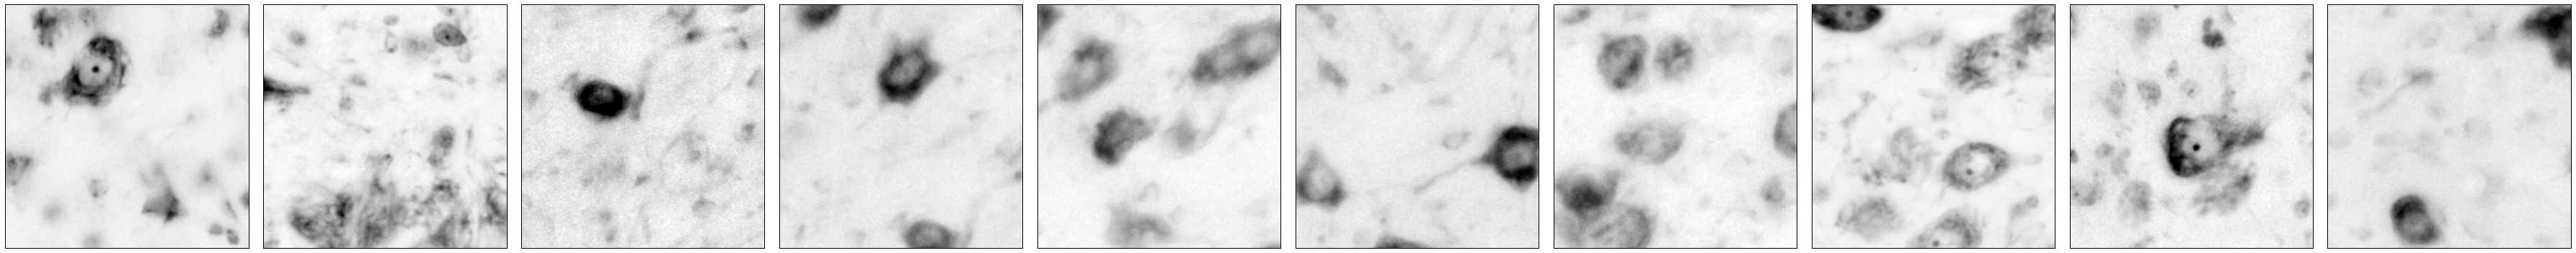

In [33]:
q = \
extract_patches_given_locations_multiple_sections(addresses=random.sample(positive_addresses_traindata, 10),
                                                  win_id=win_id, 
                                                normalization_scheme=train_scheme,
                                                 location_or_grid_index='grid_index')
display_images_in_grids(q, nc=10, cmap=plt.cm.gray, vmin=0, vmax=255)

No images are provided. Load instead.
Not using image_cache.
Load image: 17.27 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 22.20 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 17.67 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 22.43 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 17.71 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 22.75 seconds.


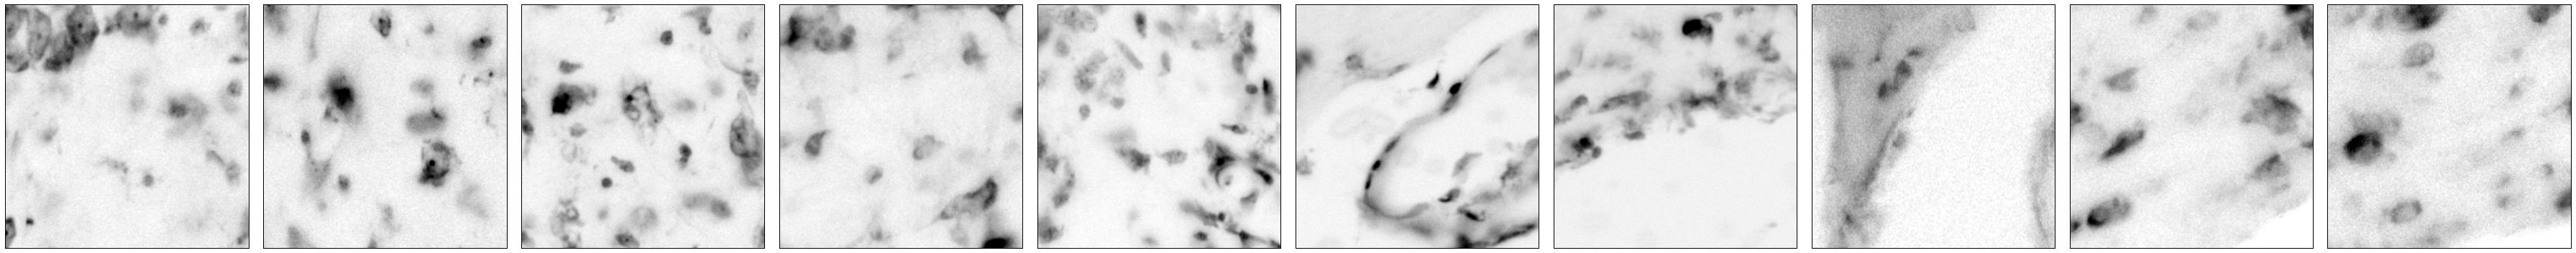

In [34]:
q = \
extract_patches_given_locations_multiple_sections(addresses=random.sample(negative_addresses_traindata, 10),
                                                  win_id=win_id, 
                                                normalization_scheme=train_scheme,
                                                 location_or_grid_index='grid_index')
display_images_in_grids(q, nc=10, cmap=plt.cm.gray, vmin=0, vmax=255)

No images are provided. Load instead.
Not using image_cache.
Load image: 13.57 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 13.46 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 12.02 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 12.54 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 12.14 seconds.


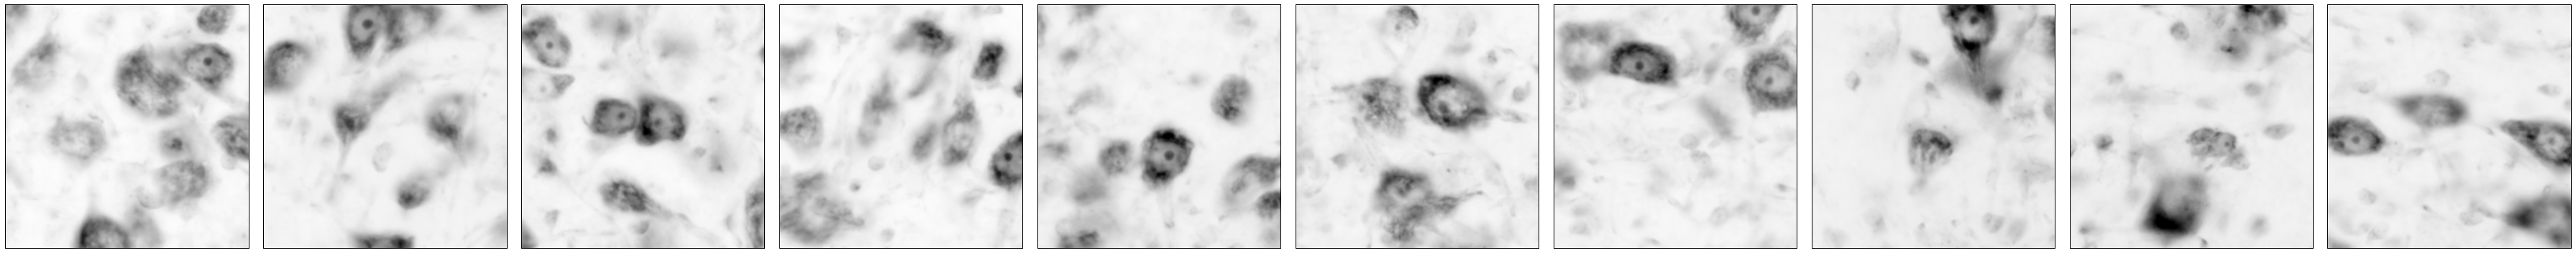

In [35]:
q = \
extract_patches_given_locations_multiple_sections(addresses=random.sample(positive_addresses_testdata, 10),
                                                  win_id=win_id, 
                                                normalization_scheme=test_scheme,
                                                 location_or_grid_index='grid_index')
display_images_in_grids(q, nc=10, cmap=plt.cm.gray, vmin=0, vmax=255)

No images are provided. Load instead.
Not using image_cache.
Load image: 11.93 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 12.27 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 13.11 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 12.32 seconds.
No images are provided. Load instead.
Not using image_cache.
Load image: 13.64 seconds.


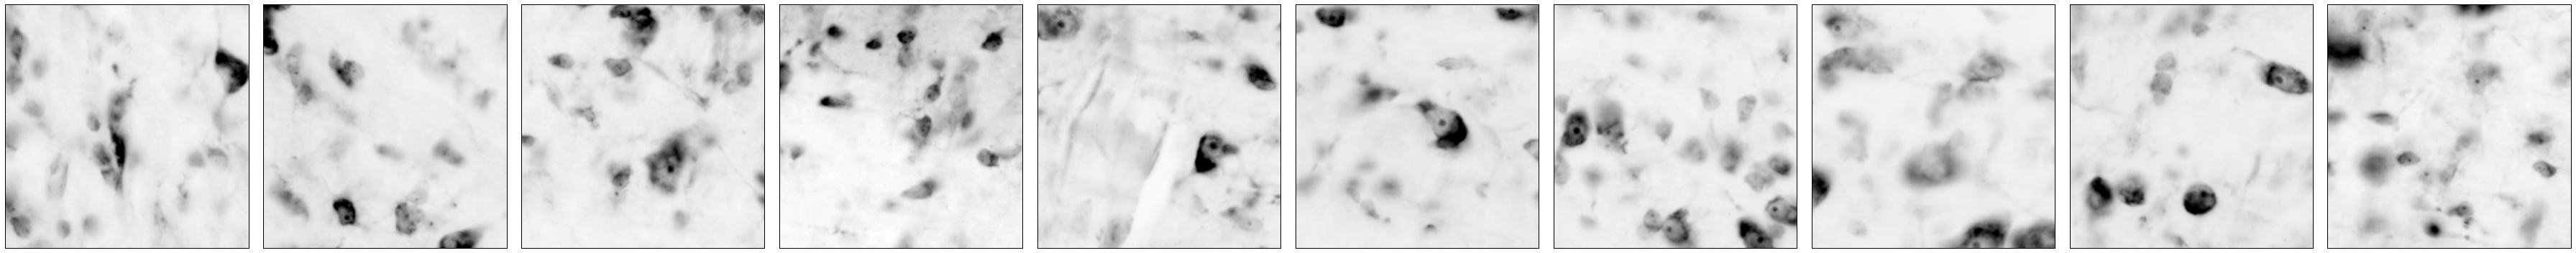

In [36]:
q = \
extract_patches_given_locations_multiple_sections(addresses=random.sample(negative_addresses_testdata, 10),
                                                  win_id=win_id, 
                                                normalization_scheme=test_scheme,
                                                 location_or_grid_index='grid_index')
display_images_in_grids(q, nc=10, cmap=plt.cm.gray, vmin=0, vmax=255)

In [83]:
[(st, metadata_cache['sections_to_filenames'][st][sec], 
  sample_locations_allStacks[st][gid]) for st,sec, gid in negative_addresses_testdata[1000:1100:10]]

[('MD661',
  'MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151',
  array([11120, 10928])),
 ('MD661',
  'MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151',
  array([11120, 11568])),
 ('MD661',
  'MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151',
  array([11184, 11248])),
 ('MD661',
  'MD662&661-F51-2017.06.06-01.06.07_MD661_1_0151',
  array([11248, 11120])),
 ('MD661',
  'MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156',
  array([ 8560, 11312])),
 ('MD661',
  'MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156',
  array([ 8624, 11440])),
 ('MD661',
  'MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156',
  array([ 8688, 11248])),
 ('MD661',
  'MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156',
  array([ 8752, 10800])),
 ('MD661',
  'MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156',
  array([ 8752, 11440])),
 ('MD661',
  'MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156',
  array([ 8816, 10864]))]

# Train

In [26]:
# n_train_list = [10, 100, 200, 500, 1000, 2000, 5000, 10000, 15000]
n_train_list = [10, 1000]
test_metrics_all_ntrain = defaultdict(lambda: defaultdict(list))
train_metrics_all_ntrain = defaultdict(lambda: defaultdict(list))

"normalize_mu_region_sigma_wholeImage_(-1,5)" is the best scheme

In [27]:
# train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# train_scheme = 'none'
# train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
# train_scheme = 'stretch_min_max'

# test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# test_scheme = 'median_curve'
# test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
# test_scheme = 'stretch_min_max'
# test_scheme = 'none'

for n_train in n_train_list:

    for trial in range(10):

        # If train and test data are from different sets
    #     n_train_pos = 5000
        n_train_pos = n_train
        if len(positive_addresses_traindata) < n_train_pos:
            continue
        training_pos_indices = np.random.choice(range(len(positive_addresses_traindata)), n_train_pos, replace=False)
        n_test_pos = 1000
        test_pos_indices = np.random.choice(range(len(positive_addresses_testdata)),
                                            size=min(len(positive_addresses_testdata), n_test_pos), 
                                            replace=False)

        # If train and test are from same set
    #     n_pos_total = len(positive_addresses)
    #     n_train_pos = 1000
    #     training_pos_indices = np.random.choice(range(n_pos_total), n_train_pos, replace=False)
    #     test_pos_indices = np.random.choice(np.setdiff1d(range(n_pos_total), training_pos_indices),
    #                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
    #     n_test_pos = len(test_pos_indices)

        ###############

        # If train and test data are from different sets
    #     n_train_neg = 5000
        n_train_neg = n_train
        training_neg_indices = np.random.choice(range(len(negative_addresses_traindata)), n_train_neg, replace=False)
        n_test_neg = 1000
        test_neg_indices = np.random.choice(range(len(negative_addresses_testdata)),
                                            size=min(len(negative_addresses_testdata), n_test_neg), 
                                            replace=False)

        # If train and test are from same set
    #     n_neg_total = len(negative_addresses)
    #     n_train_neg = 1000
    #     training_neg_indices = np.random.choice(range(n_neg_total), n_train_neg, replace=False)
    #     test_neg_indices = np.random.choice(np.setdiff1d(range(n_neg_total), training_neg_indices), 
    #                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
    #     n_test_neg = len(test_neg_indices)

        print "Training: %d positive, %d negative" % (n_train_pos, n_train_neg)
        print "Test: %d positive, %d negative" % (n_test_pos, n_test_neg)

        ################

        # If train and test data are from different sets
        addresses_train_pos = [positive_addresses_traindata[i] for i in training_pos_indices]
        addresses_test_pos = [positive_addresses_testdata[i] for i in test_pos_indices]
        addresses_train_neg = [negative_addresses_traindata[i] for i in training_neg_indices]
        addresses_test_neg = [negative_addresses_testdata[i] for i in test_neg_indices]

        # If train and test data are from same set
    #     addresses_train_pos = [positive_addresses[i] for i in training_pos_indices]
    #     addresses_test_pos = [positive_addresses[i] for i in test_pos_indices]
    #     addresses_train_neg = [negative_addresses[i] for i in training_neg_indices]
    #     addresses_test_neg = [negative_addresses[i] for i in test_neg_indices]

        #################

        for augment_training in [True, False]:
#         for augment_training in [False]:

            feature_classifier_alg = 'lr'
    #             feature_classifier_alg = 'xgb2'
    #             feature_classifier_alg = 'lin_svc'
    #             feature_classifier_alg = 'lin_svc_calib'
            sample_weights = None   

            if augment_training:
                train_transforms = range(8)
            else:
                train_transforms = range(1)
                
            test_transforms = range(1)
                
            features_train_pos = {(train_scheme, 'transform%d'%tf_variant): 
                                  [features_dict[(train_scheme, 'transform%d'%tf_variant)][addr] 
                                   for addr in addresses_train_pos]
                                      for tf_variant in train_transforms}
            features_train_neg = {(train_scheme, 'transform%d'%tf_variant): 
                                  [features_dict[(train_scheme, 'transform%d'%tf_variant)][addr] 
                                   for addr in addresses_train_neg]
                                      for tf_variant in train_transforms}
            features_test_pos = {(test_scheme, 'transform%d'%tf_variant): 
                                 [features_dict[(test_scheme, 'transform%d'%tf_variant)][addr] 
                                  for addr in addresses_test_pos]
                                     for tf_variant in test_transforms}
            features_test_neg = {(test_scheme, 'transform%d'%tf_variant): 
                                 [features_dict[(test_scheme, 'transform%d'%tf_variant)][addr]
                                  for addr in addresses_test_neg]
                                     for tf_variant in test_transforms}    
                
            if augment_training:
                
                train_data_list = []
                train_label_list = []
                for tf in range(8):
                    train_data = np.r_[features_train_pos[(train_scheme,'transform%d'%tf)], 
                                       features_train_neg[(train_scheme,'transform%d'%tf)]]
                    train_data_list.append(train_data)

                    train_labels = np.r_[np.ones((len(features_train_pos[(train_scheme,'transform%d'%tf)]), )), 
                                         -np.ones((len(features_train_neg[(train_scheme,'transform%d'%tf)]), ))]
                    train_label_list.append(train_labels)

                train_data = np.concatenate(train_data_list)
                train_labels = np.concatenate(train_label_list)        
            else:
                
                train_data = np.r_[features_train_pos[(train_scheme,'transform0')], 
                                   features_train_neg[(train_scheme,'transform0')]]
                train_labels = np.r_[np.ones((len(features_train_pos[(train_scheme,'transform0')]), )), 
                                     -np.ones((len(features_train_neg[(train_scheme,'transform0')]), ))]


            clf = train_binary_classifier(train_data, train_labels,
                                   alg=feature_classifier_alg, 
                                   sample_weights=sample_weights)

            #     trained_classifiers[structure] = clf

            #         clf_fp = DataManager.get_classifier_filepath(classifier_id=svm_id, structure=structure)
            #         create_parent_dir_if_not_exists(clf_fp)
            #         joblib.dump(clf, clf_fp)
            #         upload_to_s3(clf_fp)

            train_metrics = compute_classification_metrics(clf.predict_proba(train_data)[:,1], train_labels)
            train_metrics_all_ntrain[n_train][(train_scheme, 'augment' if augment_training else 'no-augment')].append(train_metrics)
            
            test_data = np.r_[features_test_pos[(test_scheme,'transform0')], features_test_neg[(test_scheme,'transform0')]]
            test_labels = np.r_[np.ones((len(features_test_pos[(test_scheme,'transform0')]), )), 
                                 -np.ones((len(features_test_neg[(test_scheme,'transform0')]), ))]
            test_metrics = compute_classification_metrics(clf.predict_proba(test_data)[:,1], test_labels)
#             print "acc@0.5 = %.3f, acc@opt = %.3f, opt_thresh = %.3f, auroc = %.3f, auprc = %.3f" % \
#             (test_metrics['acc'][0.5], test_metrics['acc'][test_metrics['opt_thresh']], test_metrics['opt_thresh'], test_metrics['auroc'], test_metrics['auprc'])

            test_metrics_all_ntrain[n_train][(test_scheme, 'augment' if augment_training else 'no-augment')].append(test_metrics)

train_metrics_all_ntrain.default_factory = None
test_metrics_all_ntrain.default_factory = None

Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.02 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.02 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.02 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.01 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.02 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.02 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.01 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.02 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.01 seconds
Fitting classifier: 0.00 seconds


Training: 10 positive, 10 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.01 seconds
Fitting classifier: 0.00 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.71 seconds
Fitting classifier: 0.40 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 5.40 seconds
Fitting classifier: 0.51 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.92 seconds
Fitting classifier: 0.45 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.48 seconds
Fitting classifier: 0.40 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 7.92 seconds
Fitting classifier: 0.50 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.90 seconds
Fitting classifier: 0.50 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 5.77 seconds
Fitting classifier: 0.46 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 6.93 seconds
Fitting classifier: 0.42 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 7.09 seconds
Fitting classifier: 0.48 seconds


Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 5.87 seconds
Fitting classifier: 0.40 seconds


In [8]:
# # Moved to learning_utilities.py

# def extract_one_metric(metrics_all_ntrain, which, thresh=None):
#     if thresh is None:
#         return {ntrain: {test_cond: [res[which] for res in res_all_trials]
#                    for test_cond, res_all_trials in x.iteritems()}
#          for ntrain, x in metrics_all_ntrain.iteritems()}
#     else:
#         return {ntrain: {test_cond: [res[which][thresh] for res in res_all_trials]
#                    for test_cond, res_all_trials in x.iteritems()}
#          for ntrain, x in metrics_all_ntrain.iteritems()}

In [9]:
# # Moved to learning_utilities.py

# def plot_result_wrt_ntrain(test_metrics_all_ntrain, ylabel='', title=''):

#     for test_condition in test_metrics_all_ntrain.values()[1].keys():
#         ntrains, accs, errs = zip(*sorted([(ntrain, np.mean(x[test_condition]), np.std(x[test_condition]))
#               for ntrain, x in test_metrics_all_ntrain.iteritems() if len(x) > 0]))
#         plt.errorbar(ntrains, accs, yerr=errs, label=test_condition[1]);
#     plt.xlabel('# traing patches');
#     plt.ylabel(ylabel);
#     plt.title(title);
#     plt.legend(loc='upper right');
#     plt.ylim([0.5, 1.]);
#     plt.xlim([0,16000]);
#     plt.show()

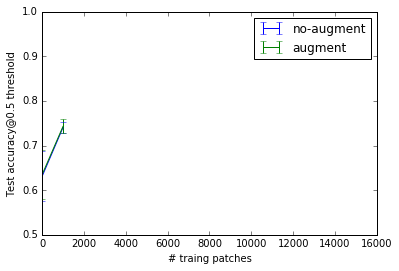

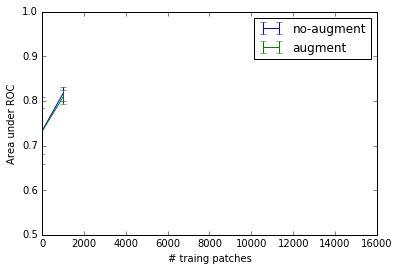

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


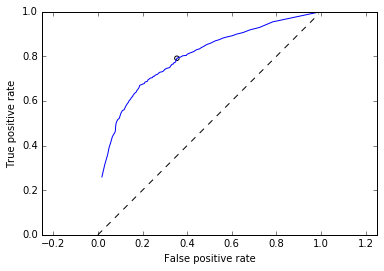

In [30]:
plot_result_wrt_ntrain(extract_one_metric(test_metrics_all_ntrain, 'acc', 0.5), ylabel='Test accuracy@0.5 threshold');
plot_result_wrt_ntrain(extract_one_metric(test_metrics_all_ntrain, 'auroc'), ylabel='Area under ROC');

plot_roc_curve(test_metrics_all_ntrain[1000][('normalize_mu_region_sigma_wholeImage_(-1,5)',
              'augment')][0]['fp'], 
               test_metrics_all_ntrain[1000][('normalize_mu_region_sigma_wholeImage_(-1,5)',
              'augment')][0]['tp'], 
              test_metrics_all_ntrain[1000][('normalize_mu_region_sigma_wholeImage_(-1,5)',
              'augment')][0]['opt_thresh']);

In [31]:
import uuid

result = {
    'n_train_sections': train_stack_section_number,
    'n_test_sections': test_stack_section_number,
    'train_stain': train_stack_stain,
    'test_stain': test_stack_stain,
    'train_stack': train_stack,
    'test_stack': test_stack,
    'test_scheme': test_scheme,
    'train_scheme': train_scheme,
    'train_metrics_all_ntrain': train_metrics_all_ntrain,
    'test_metrics_all_ntrain': test_metrics_all_ntrain
}

create_if_not_exists(ROOT_DIR + '/assessment_results_v2/')
save_pickle(result, ROOT_DIR + '/assessment_results_v2/assessment_result_%s.pkl' % str(uuid.uuid1()).split('-')[0])

# Inspect scoremap for local regions around a certain landmark.

In [200]:
from data_manager import *

In [201]:
DataManager.clear_image_cache()

In [22]:
# local_region_bbox_all_structures_all_sections = get_local_regions(stack='ChatCryoJane201710')
local_region_bbox_all_structures_all_sections = get_local_regions(stack=test_stack, margin_um=5000)

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/ChatCryoJane201710" "/home/yuncong/CSHL_labelings_v3/ChatCryoJane201710" --exclude "*" --include "*contours*"
latest timestamp:  12132017032001


In [23]:
# train_scheme = 'none'
# train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# test_scheme = 'median_curve'
# train_scheme = 'stretch_min_max'
# test_scheme = 'stretch_min_max'

n_train = 2000

# If train and test data are from different sets
#     n_train_pos = 5000
n_train_pos = n_train
# if len(positive_addresses_traindata) < n_train_pos:
#     continue
training_pos_indices = np.random.choice(range(len(positive_addresses_traindata)), n_train_pos, replace=False)

###############

# If train and test data are from different sets
#     n_train_neg = 5000
n_train_neg = n_train
training_neg_indices = np.random.choice(range(len(negative_addresses_traindata)), n_train_neg, replace=False)

print "Training: %d positive, %d negative" % (n_train_pos, n_train_neg)
# print "Test: %d positive, %d negative" % (n_test_pos, n_test_neg)

################

# If train and test data are from different sets
addresses_train_pos = [positive_addresses_traindata[i] for i in training_pos_indices]
addresses_train_neg = [negative_addresses_traindata[i] for i in training_neg_indices]

#################

augment_training = False

feature_classifier_alg = 'lr'
#             feature_classifier_alg = 'xgb2'
#             feature_classifier_alg = 'lin_svc'
#             feature_classifier_alg = 'lin_svc_calib'
sample_weights = None   

if augment_training:
    train_transforms = range(8)
else:
    train_transforms = range(1)

test_transforms = range(1)

features_train_pos = {(train_scheme, 'transform%d'%tf_variant): 
                      [features_dict[(train_scheme, 'transform%d'%tf_variant)][addr] 
                       for addr in addresses_train_pos]
                          for tf_variant in train_transforms}
features_train_neg = {(train_scheme, 'transform%d'%tf_variant): 
                      [features_dict[(train_scheme, 'transform%d'%tf_variant)][addr] 
                       for addr in addresses_train_neg]
                          for tf_variant in train_transforms}

if augment_training:

    train_data_list = []
    train_label_list = []
    for tf in range(8):
        train_data = np.r_[features_train_pos[(train_scheme,'transform%d'%tf)], 
                           features_train_neg[(train_scheme,'transform%d'%tf)]]
        train_data_list.append(train_data)

        train_labels = np.r_[np.ones((len(features_train_pos[(train_scheme,'transform%d'%tf)]), )), 
                             -np.ones((len(features_train_neg[(train_scheme,'transform%d'%tf)]), ))]
        train_label_list.append(train_labels)

    train_data = np.concatenate(train_data_list)
    train_labels = np.concatenate(train_label_list)        
else:

    train_data = np.r_[features_train_pos[(train_scheme,'transform0')], 
                       features_train_neg[(train_scheme,'transform0')]]
    train_labels = np.r_[np.ones((len(features_train_pos[(train_scheme,'transform0')]), )), 
                         -np.ones((len(features_train_neg[(train_scheme,'transform0')]), ))]


clf = train_binary_classifier(train_data, train_labels,
                       alg=feature_classifier_alg, 
                       sample_weights=sample_weights)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [134]:
# base_image_cache = {sec: DataManager.load_image_v2(stack='ChatCryoJane201710', prep_id=2, version='NtbJpeg', section=sec)
#                    for sec in range(90, 130, 5)}

# base_image_cache = {sec: DataManager.load_image_v2(stack='MD661', prep_id=2, version='grayJpeg', section=sec)
# #                    for sec in range(90, 130, 5)
#                     for sec in local_region_bbox_all_structures_all_sections['7N_L'].keys()[::10]
#                    }

In [288]:
metadata_cache['sections_to_filenames']['ChatCryoJane201710'][113]

'ChatCryoJane201710_slide37-S3'

In [ ]:
metadata_cache['sections_to_filenames']['MD661'][150]

In [35]:
DataManager.disable_image_cache()

In [ ]:
# for sec in local_region_bbox_all_structures_all_sections['7N_L'].keys()[::10]:
for sec in [113]:
    viz = draw_scoremap(clf=clf, structure='7N_L', 
                        scheme=test_scheme,
                        bbox=local_region_bbox_all_structures_all_sections['7N_L'][sec], 
                        stack=test_stack, sec=sec,
#                        bg_img=base_image_cache[sec],
                       feature='cnn', model=model, mean_img=mean_img, batch_size=batch_size)
    plt.figure(figsize=(20,20));
    plt.imshow(viz);
    plt.show();

# ROC

In [39]:
negative_composition_rules = ['surround500']

In [40]:
fixed_n_pos = 500
fixed_n_neg = 500

In [239]:
acc_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
tp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
# fn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
fp_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
# tn_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
precision_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
recall_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
f1score_normalized_all_clfs_all_structures_all_negcomprule =  defaultdict(lambda: defaultdict(dict))

classifier_ids = [0]

for classifier_id in classifier_ids:
    
    clf_allClasses = trained_classifiers

    ####################################################
    # Compute accuracy against each structure surround #
    ####################################################
    
    for neg_composition_rule in negative_composition_rules:
            
        ncols = 5
        nrows = int(np.ceil(len(structures_found)/float(ncols)))

    #     fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
    #     axes = axes.flatten()

        for i, structure in enumerate(structures_found):

#             features_pos = test_features[structure]
            features_pos = features_pos_unused
    
            if fixed_n_pos is not None:
                features_pos = features_pos[np.random.choice(range( len(features_pos)), replace=False, size=(min(fixed_n_pos, len(features_pos)),))]

            n_pos = len(features_pos)
            print structure, n_pos, 'positive'

            if neg_composition_rule.startswith('surround'):
                if neg_composition_rule == 'surround200':
                    margin_um = 200
                elif neg_composition_rule == 'surround500':
                    margin_um = 500
                elif neg_composition_rule == 'surround1000':
                    margin_um = 1000
                else:
                    margin_um = None
                neg_classes = [convert_to_surround_name(structure, margin=margin_um, suffix='noclass')] + \
                [convert_to_surround_name(structure, margin=margin_um, suffix=surr_l) for surr_l in structures_found]
            elif neg_composition_rule == 'negative':
                neg_classes = [structure + '_negative']
            else:
                raise
            
            neg_classes = list(set(neg_classes) & set(labels_found))

#             features_neg = np.vstack([test_features[neg_class] for neg_class in neg_classes])
            features_neg = features_neg_unused
    
            if fixed_n_neg is not None:
                features_neg = features_neg[np.random.choice(range( len(features_neg)), replace=False, size=(min(fixed_n_neg, len(features_neg)),))]        

            n_neg = len(features_neg)
            print structure, n_neg, 'negative'

            test_data = np.r_[features_pos, features_neg]
            test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                                 -np.ones((features_neg.shape[0], ))]

            if structure not in clf_allClasses:
                sys.stderr.write('Classifier for structure %s does not exist.\n' %  structure)
                continue

            clf = clf_allClasses[structure]

            probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
            
            
            ######### SOFT ########
#             cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
#                                              normalize=False)
#             tp = cm[0,0]
#             fn = cm[0,1]
#             fp = cm[1,0]
#             tn = cm[1,1]

#             acc = (tp + tn) / (n_pos + n_neg)
#             acc_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = acc

            ######## PRECISION-RECALL ########
            precision_allthresh = {}
            recall_allthresh = {}
            f1score_allthresh = {}
            tp_normalized_allthresh = {}
            fp_normalized_allthresh = {}
            for th in np.arange(0., 1., 0.01):
            
                cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=False,
                                             normalize=False, binary=True, decision_thresh=th)

                tp = cm[0,0]
                fn = cm[0,1]
                fp = cm[1,0]
                tn = cm[1,1]
                
                tp_normalized = tp / n_pos
#                 fn_normalized = fn / n_pos
                fp_normalized = fp / n_neg
#                 tn_normalized = tn / n_neg

                precision = float(tp) / (tp + fp)
                recall = float(tp) / (tp + fn)
                f1score = 2*recall*precision/(recall+precision)
                
                tp_normalized_allthresh[float(th)] = tp_normalized
                fp_normalized_allthresh[float(th)] = fp_normalized
                precision_allthresh[float(th)] = precision
                recall_allthresh[float(th)] = recall
                f1score_allthresh[float(th)] = f1score

            tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tp_normalized_allthresh
#             fn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fn_normalized_allthresh
            fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = fp_normalized_allthresh
#             tn_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = tn_normalized_allthresh
            precision_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = precision_allthresh
            recall_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = recall_allthresh
            f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][structure][neg_composition_rule] = f1score_allthresh
    #     plt.tight_layout()

        ############################

#         xticks = range(1, 1 + len(structures_sorted_by_size))

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [acc_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size]);
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylim([0.6, 1]);
#         plt.ylabel('Accuracy');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.show();

#         print 'test accuracy:', np.mean(acc_all_clfs_all_structures[classifier_id].values())

#         plt.figure(figsize=(10, 1.2));
#         plt.stem(xticks, [tp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tp', markerfmt='bo');
#         plt.stem(xticks, [fn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fn', markerfmt='ro');
#         plt.stem(xticks, [fp_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='fp', markerfmt='ko');
#         plt.stem(xticks, [tn_normalized_all_clfs_all_structures[classifier_id][s] for s in structures_sorted_by_size], label='tn', markerfmt='go');
#         plt.xticks(xticks, structures_sorted_by_size, rotation='60');
#         plt.ylabel('Percentage');
#         plt.xlabel('Structure Name');
#         plt.title('Accuracy, %s, classifier %d' % (neg_composition_rule, classifier_id));
#         plt.legend();
#         plt.show();

tp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
# fn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
fp_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
# tn_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
precision_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
recall_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None
f1score_normalized_all_clfs_all_structures_all_negcomprule.default_factory = None

SNR 500 positive
SNR 500 negative


In [240]:
structures_sorted_by_size = ['SNR']

In [241]:
fopt_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))
optthresh_normalized_all_clfs_all_structures_all_negcomprule = defaultdict(lambda: defaultdict(dict))

for classifier_id in classifier_ids:

    for neg_composition_rule in negative_composition_rules:

        for s in structures_sorted_by_size:
            fp_allthresh = fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            tp_allthresh = tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            f_allthresh = f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]

            optimal_th = np.arange(0, 1, 0.01)[np.nanargmax([f_allthresh[th] for th in np.arange(0, 1, 0.01)])]
            optthresh_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] = optimal_th
            fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] = f_allthresh[optimal_th]

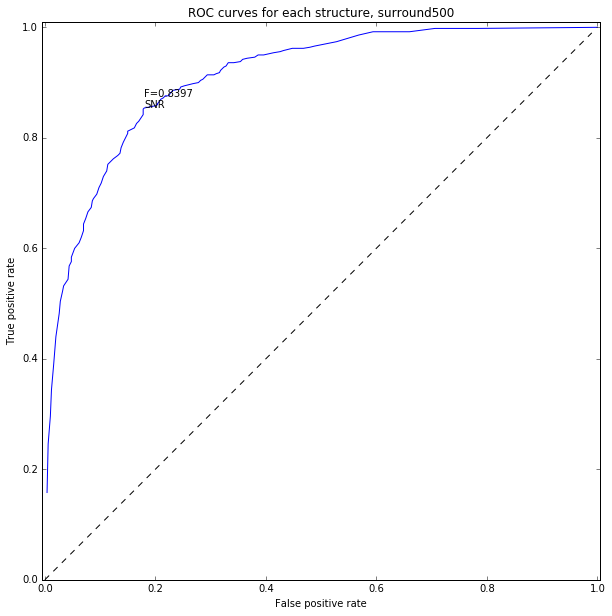

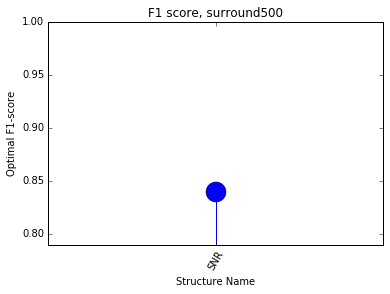

In [242]:
for classifier_id in classifier_ids:
    for neg_composition_rule in negative_composition_rules:

    #     plt.figure(figsize=(15, 10));
        plt.figure(figsize=(10, 10));
        plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='k', linestyle='--');

        fopt = {}
        for s in structures_sorted_by_size:
            fp_allthresh = fp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            tp_allthresh = tp_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            f_allthresh = f1score_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]

            plt.plot([fp_allthresh[float(th)] for th in np.arange(0, 1, 0.01)],
                 [tp_allthresh[float(th)] for th in np.arange(0, 1, 0.01)]);

            optimal_th = optthresh_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule]
            fopt = f_allthresh[optimal_th]

    #         plt.scatter(fp_allthresh[optimal_th], tp_allthresh[optimal_th], 
    #             marker='o', facecolors='none', edgecolors='k')
            plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th]+.02, 'F=%.4f' % (fopt))
            plt.text(fp_allthresh[optimal_th], tp_allthresh[optimal_th], s, fontsize=10)

    #     plt.legend();
        plt.ylabel('True positive rate');
        plt.xlabel('False positive rate');
    #     plt.xticks(np.arange(0,1,.1));
        plt.axis('equal');
        plt.ylim([0,1.01]);
        plt.xlim([0,1]);
        plt.title('ROC curves for each structure, %s' % (neg_composition_rule));
        plt.show();

    #     plt.figure();
    #     plt.hist(fopt.values(), bins=np.arange(0.7, 1.0, 0.01));
    #     plt.ylabel("Number of structures");
    #     plt.xlabel("Optimal f1 score");
    #     plt.show();

        plt.figure();
        xticks = range(1, 1 + len(structures_sorted_by_size))
        (markerLines, stemLines, baseLines) = plt.stem(xticks, 
                                                       [fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                                                        for s in structures_sorted_by_size],
         markerfmt='o', markevery=[4,8]);
        plt.setp(markerLines, markersize=20, alpha=1.)
        plt.xticks(xticks, structures_sorted_by_size, rotation='60');
        plt.ylabel('Optimal F1-score');
        plt.xlabel('Structure Name');
        plt.ylim(np.min([fopt_normalized_all_clfs_all_structures_all_negcomprule[classifier_id][s][neg_composition_rule] 
                                                        for s in structures_sorted_by_size])-.05, 1);
        plt.title('F1 score, %s' % (neg_composition_rule));
        plt.legend();
        plt.show();